# BMI 206 Individual Project

In [163]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from tabulate import tabulate
from scipy.stats import permutation_test
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.multitest import multipletests
from scipy.stats import spearmanr

# Define Function to calculate BrC with modifications in Kim et al.(2019)
$$
\mathrm{BrC}(i) = B(i)\times BC(i)
$$
$$
BC(i)\neq 0 \quad \text{only if } k_i^{in}>0 \text{ and } k_i^{out}>0
$$


In [2]:
def calculate_bridging_centrality(g):
    # 1. Calculate Betweenness
    betweenness = nx.betweenness_centrality(g, normalized=True)    
    bridging_coefficient = {}
    total_degrees = dict(g.degree())     
    # 2. Calculate Bridging Coefficient
    for node in g.nodes():
        d_total_i = total_degrees[node]
        
        predecessors = list(g.predecessors(node))
        successors = list(g.successors(node))
        
        if len(predecessors) == 0 or len(successors) == 0:
            bridging_coefficient[node] = 0.0
            continue        
        # Combine neighbors 
        all_neighbors = list(set(predecessors + successors))
        
        if d_total_i == 0 or not all_neighbors:
            bridging_coefficient[node] = 0.0
            continue
        
        sum_inv_deg_neighbor = 0 
        for neighbor in all_neighbors:
            d_total_neighbor = total_degrees[neighbor]
            if d_total_neighbor > 0:
                sum_inv_deg_neighbor += (1 / d_total_neighbor)
        
        if sum_inv_deg_neighbor == 0:
            bridging_coefficient[node] = 0.0
        else: 
            numerator = 1 / d_total_i
            bridging_coefficient[node] = numerator / sum_inv_deg_neighbor
    # 3. Calculate Final BRC
    bridging_centrality = {}
    for node in g.nodes():
        bridging_centrality[node] = betweenness[node] * bridging_coefficient.get(node, 0.0)
    
    return bridging_centrality

# Bridging Centrality (BrC) Calculation Pipeline

## Overview
Bridging Centrality (BrC) was computed from the pre-processed reaction–reaction adjacency matrices provided by Kim et al. (2019). These matrices were used to reconstruct directed, reaction-centric metabolic networks and identify topological bottleneck reactions.

## Workflow
- **Load adjacency matrices:** Import species-specific reaction–reaction adjacency matrices from the provided Excel file.
- **Graph construction:** Convert each adjacency matrix into a directed graph using `networkx`.
- **BrC computation:** Calculate Bridging Centrality for each reaction using the `calculate_bridging_centrality` function.
- **Post-processing:** Filter out zero-valued BrC scores and aggregate results across species into a unified dataframe (`final_df`).



In [9]:
all_species_data = []
file_path = '/Users/kevindai/UCSF_Fall_2025/gwas 2/12859_2019_2897_MOESM2_ESM.xlsx'
sheet_names = ['E.coli (iJ01366)', 'B. subtilis (iYO844)', 
               'G. metallireducens (iAF987)', 'K. pneumoniae (iYL1228)', 
               'S. cerevisiae (iMM904)']

for name in sheet_names:
    print(f"Processing {name}...")
    
    raw_df = pd.read_excel(file_path, index_col=0, sheet_name=name)
    
    if raw_df.shape[0] != raw_df.shape[1]:
        print(f"Warning: Matrix for {name} is not square! {raw_df.shape}")
        continue  # skip this species safely
    
    G = nx.from_pandas_adjacency(raw_df, create_using=nx.DiGraph)
    
    brc_results = calculate_bridging_centrality(G)
    
    for node, score in brc_results.items():
        if score > 0:  # filter zeros
            all_species_data.append({
                'Species': name,
                'Reaction_ID': node,
                'BRC': score
            })

final_df = pd.DataFrame(all_species_data)
print(final_df.head())


Processing E.coli (iJ01366)...
Processing B. subtilis (iYO844)...
Processing G. metallireducens (iAF987)...
Processing K. pneumoniae (iYL1228)...
Processing S. cerevisiae (iMM904)...
            Species   Reaction_ID       BRC
0  E.coli (iJ01366)       APH120   0.000005
1  E.coli (iJ01366)   FA120ACPHi   0.000100
2  E.coli (iJ01366)    FACOAE120   0.000127
3  E.coli (iJ01366)   2AGPGAT120   0.000143
4  E.coli (iJ01366)       AACPS7   0.000033


In [69]:
# Check Dataframe - Sanity check
final_df.info

<bound method DataFrame.info of                      Species   Reaction_ID       BRC
0           E.coli (iJ01366)       APH120   0.000005
1           E.coli (iJ01366)   FA120ACPHi   0.000100
2           E.coli (iJ01366)    FACOAE120   0.000127
3           E.coli (iJ01366)   2AGPGAT120   0.000143
4           E.coli (iJ01366)       AACPS7   0.000033
...                      ...           ...       ...
4153  S. cerevisiae (iMM904)    CERS224er   0.000002
4154  S. cerevisiae (iMM904)    CERS226er   0.000002
4155  S. cerevisiae (iMM904)     G6PDH2er   0.000003
4156  S. cerevisiae (iMM904)      SBPP1er   0.000006
4157  S. cerevisiae (iMM904)      SBPP2er   0.000006

[4158 rows x 3 columns]>

# Distribution of Bridging Centrality (BrC) by Species

To compare the distribution of bottlenecks across species, Bridging Centrality values were analyzed at multiple thresholds.

## Workflow
- **Rank reactions:** Sort reactions within each species by their BrC values.
- **Select top thresholds:** Extract the upper tail of the distribution, focusing on the top 25 and top 50 BrC-ranked reactions.
- **Visualization:** Visualize BrC distributions across species using Seaborn boxplots with overlaid stripplots to highlight individual high-impact reactions.


In [201]:
def box_strip_plot(
    df,
    x_value,
    y_value,
    identifier,
    colors,
    title,
    sort_by=None,
    ascending=False,
    show_fliers=False,
    strip_color="black",
    strip_alpha=0.2,
    strip_size=5,
    jitter=True,
    figsize=(5, 7),
    ax=None
):
    plot_df = df.copy()

    if sort_by is not None:
        plot_df = plot_df.sort_values(by=sort_by, ascending=ascending)

    # Create figure only if no axis is provided
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        created_fig = True

    sns.boxplot(
        data=plot_df,
        x=x_value,
        y=y_value,
        hue=identifier,
        palette=colors,
        showfliers=show_fliers,
        dodge=False,
        ax=ax
    )

    sns.stripplot(
        data=plot_df,
        x=x_value,
        y=y_value,
        color=strip_color,
        alpha=strip_alpha,
        size=strip_size,
        jitter=jitter,
        ax=ax
    )

    ax.set_xlabel("")
    ax.set_ylabel(y_value)
    ax.set_title(title)
    ax.tick_params(axis="x", rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha("right")

    # Remove duplicate legend (since hue == x)
    if ax.get_legend() is not None:
        ax.get_legend().remove()

    if created_fig:
        plt.tight_layout()
        plt.show()

    return ax


In [95]:
# Filter final_df for top 50 and top 25 rxn's
# Def function to get top nodes
def get_top_nodes(df, number):
    top_nodes = (
        df.groupby('Species')
          .apply(lambda x: x.nlargest(number, 'BRC'))
          .reset_index(drop=True)
    )
    return top_nodes

In [97]:
top_50 = get_top_nodes(final_df,50)
top_25 = get_top_nodes(final_df,25)
print(top_25,top_50)

                    Species Reaction_ID       BRC
0      B. subtilis (iYO844)     CDPMEK   0.024807
1      B. subtilis (iYO844)      HISTP   0.016228
2      B. subtilis (iYO844)     DXPRIi   0.012967
3      B. subtilis (iYO844)    DHNAOT7   0.011090
4      B. subtilis (iYO844)     DHDPRy   0.009780
..                      ...         ...       ...
120  S. cerevisiae (iMM904)    ACONT3m   0.003693
121  S. cerevisiae (iMM904)    C4STMO1   0.003614
122  S. cerevisiae (iMM904)       FDNG   0.003445
123  S. cerevisiae (iMM904)      RNTR1   0.003440
124  S. cerevisiae (iMM904)     ALDD2y   0.003424

[125 rows x 3 columns]                     Species Reaction_ID       BRC
0      B. subtilis (iYO844)     CDPMEK   0.024807
1      B. subtilis (iYO844)      HISTP   0.016228
2      B. subtilis (iYO844)     DXPRIi   0.012967
3      B. subtilis (iYO844)    DHNAOT7   0.011090
4      B. subtilis (iYO844)     DHDPRy   0.009780
..                      ...         ...       ...
245  S. cerevisiae (iMM904

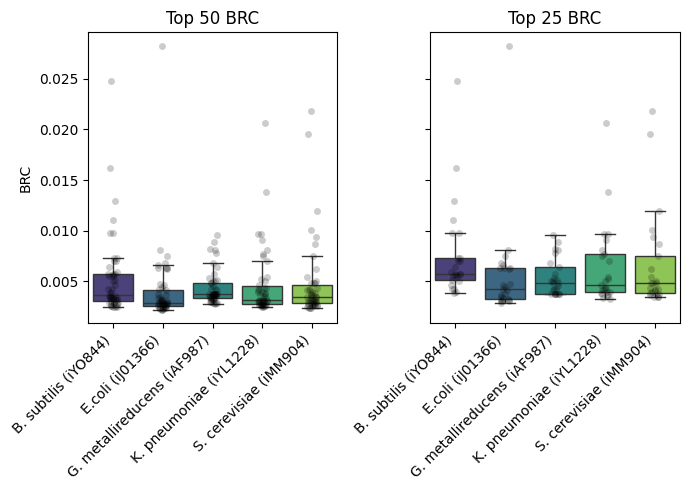

In [211]:
fig, axes = plt.subplots(1, 2, figsize=(7, 5), sharey=True)

# Panel A — Top 50
box_strip_plot(
    top_50,
    x_value="Species",
    y_value="BRC",
    identifier="Species",
    colors="viridis",
    sort_by=["Species", "BRC"],
    ascending=True,
    title="Top 50 BRC",
    ax=axes[0]
)

# Panel B — Top 25
box_strip_plot(
    top_25,
    x_value="Species",
    y_value="BRC",
    identifier="Species",
    colors="viridis",
    sort_by=["Species", "BRC"],
    ascending=True,
    title="Top 25 BRC",
    ax=axes[1]
)

plt.tight_layout()
plt.show()


# Permutation Testing of Top Bridging Reactions

To determine whether any species pairs exhibit statistically significant differences in the mean Bridging Centrality (BrC) of their top-ranked reactions, we performed pairwise permutation tests.

## Workflow
- **Select top-ranked reactions:** For each species, the top *N* reactions were selected based on BrC values.
- **Define test statistic:** The difference in mean BrC between two species was used as the test statistic.
- **Generate null distribution:** Species labels were randomly permuted to construct an empirical null distribution for the test statistic.
- **Assess significance:** Two-sided p-values were computed by comparing the observed statistic to the null distribution.
- **Multiple testing correction:** P-values were adjusted using false discovery rate (FDR) correction to account for multiple pairwise comparisons.


In [142]:
# Function for difference in means for x & y
def diff_in_means(x, y):
    return np.mean(x) - np.mean(y)

# Define function for pairwise_permutation test
def pairwise_permutation_tests(
    df,
    species_col="Species",
    value_col="BRC",
    n_resamples=10000,
    alpha=0.05
):
    species_list = df[species_col].unique()
    results = []

    for s1, s2 in combinations(species_list, 2):
        group_a = df[df[species_col] == s1][value_col].values
        group_b = df[df[species_col] == s2][value_col].values

        res = permutation_test(
            (group_a, group_b),
            diff_in_means,
            n_resamples=n_resamples,
            alternative="two-sided"
        )

        results.append({
            "Species A": s1,
            "Species B": s2,
            "P-value": res.pvalue
        })

    results_df = pd.DataFrame(results)

    # Multiple testing correction (Benjamini-Hochberg)
    results_df["Adj P-value"] = multipletests(
        results_df["P-value"],
        method="fdr_bh"
    )[1]

    results_df["Result"] = np.where(
        results_df["Adj P-value"] < alpha,
        "Significant (*)",
        "Not Significant"
    )

    return results_df


In [144]:
pairwise_permutation_tests(top_25)

,Species A,Species B,P-value,Adj P-value,Result
0,B. subtilis (iYO844),E.coli (iJ01366),0.151185,0.653135,Not Significant
1,B. subtilis (iYO844),G. metallireducens (iAF987),0.017998,0.179982,Not Significant
2,B. subtilis (iYO844),K. pneumoniae (iYL1228),0.326567,0.653135,Not Significant
3,B. subtilis (iYO844),S. cerevisiae (iMM904),0.479352,0.690217,Not Significant
4,E.coli (iJ01366),G. metallireducens (iAF987),0.956104,0.956104,Not Significant
5,E.coli (iJ01366),K. pneumoniae (iYL1228),0.581142,0.726427,Not Significant
6,E.coli (iJ01366),S. cerevisiae (iMM904),0.483152,0.690217,Not Significant
7,G. metallireducens (iAF987),K. pneumoniae (iYL1228),0.289171,0.653135,Not Significant
8,G. metallireducens (iAF987),S. cerevisiae (iMM904),0.254575,0.653135,Not Significant
9,K. pneumoniae (iYL1228),S. cerevisiae (iMM904),0.850715,0.945239,Not Significant


In [146]:
pairwise_permutation_tests(top_50)

,Species A,Species B,P-value,Adj P-value,Result
0,B. subtilis (iYO844),E.coli (iJ01366),0.124588,0.622938,Not Significant
1,B. subtilis (iYO844),G. metallireducens (iAF987),0.115188,0.622938,Not Significant
2,B. subtilis (iYO844),K. pneumoniae (iYL1228),0.346965,0.759924,Not Significant
3,B. subtilis (iYO844),S. cerevisiae (iMM904),0.459354,0.759924,Not Significant
4,E.coli (iJ01366),G. metallireducens (iAF987),0.759324,0.843693,Not Significant
5,E.coli (iJ01366),K. pneumoniae (iYL1228),0.497550,0.759924,Not Significant
6,E.coli (iJ01366),S. cerevisiae (iMM904),0.420358,0.759924,Not Significant
7,G. metallireducens (iAF987),K. pneumoniae (iYL1228),0.644936,0.806169,Not Significant
8,G. metallireducens (iAF987),S. cerevisiae (iMM904),0.531947,0.759924,Not Significant
9,K. pneumoniae (iYL1228),S. cerevisiae (iMM904),0.875912,0.875912,Not Significant


# Spearman Correlation Analysis of Bridging Centrality Profiles

To assess whether metabolic bottlenecks exhibit similar topological importance across species, we performed Spearman rank correlation analyses on Bridging Centrality (BrC) values.

## Workflow
- **Select top-ranked reactions:** For each species, the top *N* reactions were selected based on BrC values.
- **Identify shared reactions:** For each species pair, reactions appearing in the top *N* list of both species were identified.
- **Construct aligned vectors:** BrC values for shared reactions were aligned by reaction identifier to ensure direct comparability between species.
- **Correlation analysis:** Spearman rank correlation was computed on the aligned BrC vectors to quantify similarity in relative topological importance.
- **Minimum overlap requirement:** Correlations were computed only when a minimum number of shared reactions was present, ensuring statistical interpretability.

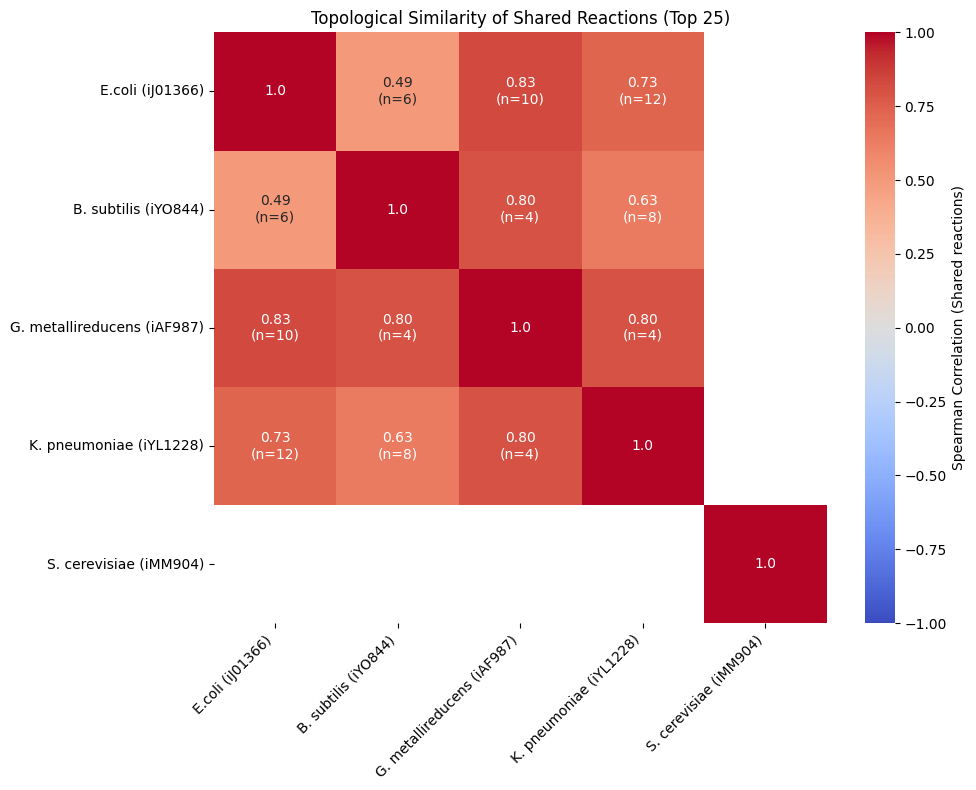

In [179]:
TOP_N = 25  # Top rated BrC definition
MIN_OVERLAP = 3 # how much overlap must be present between pairs

species_list = final_df['Species'].unique()
n_species = len(species_list)
corr_matrix = np.zeros((n_species, n_species))
annot_matrix = np.empty((n_species, n_species), dtype=object)
for i, sp_a in enumerate(species_list):
    for j, sp_b in enumerate(species_list):
        if i == j:
            corr_matrix[i, j] = 1.0
            annot_matrix[i, j] = "1.0"
            continue
            
        # Get Top N for Species A and Species B
        top_a = final_df[final_df['Species'] == sp_a].nlargest(TOP_N, 'BRC')
        top_b = final_df[final_df['Species'] == sp_b].nlargest(TOP_N, 'BRC')
        common_ids = set(top_a['Reaction_ID']).intersection(set(top_b['Reaction_ID']))
        overlap_count = len(common_ids)
        
        if overlap_count >= MIN_OVERLAP:
            # We must SORT by ID to ensure Vector A aligns perfectly with Vector B
            vec_a = top_a[top_a['Reaction_ID'].isin(common_ids)].sort_values('Reaction_ID')
            vec_b = top_b[top_b['Reaction_ID'].isin(common_ids)].sort_values('Reaction_ID')
            
            # Run Spearman on the BRC scores
            rho, p_val = spearmanr(vec_a['BRC'], vec_b['BRC'])            
            corr_matrix[i, j] = rho
            annot_matrix[i, j] = f"{rho:.2f}\n(n={overlap_count})" # Show Score AND Count
            
        else:
            # Not enough overlap to be statistically valid
            corr_matrix[i, j] = np.nan
            annot_matrix[i, j] = "N/A"

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=annot_matrix, fmt="", cmap='coolwarm', 
            vmin=-1, vmax=1, center=0,
            xticklabels=species_list, yticklabels=species_list,
            cbar_kws={'label': 'Spearman Correlation (Shared reactions)'})

plt.title(f'Topological Similarity of Shared Reactions (Top {TOP_N})')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()